In [36]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib

model_rfr = joblib.load('savemodel_rfr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [37]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [38]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
count,7453.000000,7453.000000,5941.000000,5941.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.016286,0.003318,8.870751,242.699284
std,5.296850,4.429899,0.099475,0.081795,8.619512,108.555287
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241
25%,-1.756650,-2.534061,-0.037983,-0.044471,0.000000,124.116508
50%,2.294543,0.385690,0.019269,0.003562,6.953578,283.216008
75%,5.838650,3.339456,0.072372,0.047412,18.014436,346.200000
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115


In [39]:
dfpre["True North Wind Direction"] =  180 +  np.rad2deg(np.arctan((dfpre["eastwind"])/(dfpre["northwind"])))

# dfpre["True North Wind Direction"] = np.where(dfpre["True North Wind Direction"] > 0, 180 + dfpre["True North Wind Direction"] , 180 - dfpre["True North Wind Direction"])

# if dfpre["True North Wind Direction"]<0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]
# elif dfpre["True North Wind Direction"]>0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]

In [40]:
dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

In [41]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [42]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,Wind Speed,Current Speed,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,7.112664,0.122270,155.408180,105.591753,22.854050,22.749664,22.610062,198.591820,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,6.653538,0.122270,158.458891,105.591753,26.122772,19.152008,22.209274,195.541109,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,6.488697,0.099846,163.749663,116.740448,28.498383,12.424912,20.857971,190.250337,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,6.104632,0.099846,170.724504,116.740448,29.956985,6.725922,18.732071,183.275496,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,6.181707,0.099846,179.505940,116.740448,34.486298,3.761627,15.731430,174.494060,57.259552


In [43]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [44]:
# Exclude data for the month of June to check the model's forecasting performance 
dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

In [45]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,Wind Speed,Current Speed,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,True North Wind Direction,True North Current Direction
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,10.248966,0.144914,100.989288,164.871808,15.554049,66.843493,57.268527,201.771601,85.654121
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,11.364678,0.246220,108.737155,153.650411,11.071672,60.455881,51.313932,205.671971,70.585227
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,12.666946,0.284315,114.910729,153.031589,16.281358,57.086511,46.894106,212.436488,70.557348
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,13.386999,0.300428,123.568984,153.643227,69.175152,55.507286,56.527939,230.510505,80.584748
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,12.053293,0.262897,26.476633,41.766758,158.632374,159.050718,167.192888,254.157471,89.447596


In [71]:
stats1 = dfdate6.describe()
print(stats1)

       oceantemperature  waveheight  swellperiod  windwaveperiod  waveperiod  \
count        322.000000  287.000000   287.000000      287.000000  287.000000   
mean         287.133146    1.256461     3.748657        3.225762    3.411435   
std            6.306975    1.116250     1.205785        1.020217    1.018301   
min          269.606903    0.123628     1.915932        1.570717    1.915993   
25%          285.292786    0.450690     2.812984        2.392128    2.656420   
50%          289.505615    0.793307     3.481734        3.107826    3.125275   
75%          291.391602    1.594712     4.450458        3.864906    3.919880   
max          294.685303    4.908680     7.260825        6.225745    6.291378   

         surftemp  windwaveswellheight  swellheight  windwaveheight  \
count  305.000000           287.000000   287.000000    2.870000e+02   
mean   287.261956             0.665559     0.330459    5.125105e-01   
std      4.927599             0.572845     0.201665    5.878202e-0

In [47]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [48]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)


In [49]:
imputer.fit(dfdate6)

KNNImputer(n_neighbors=50)

In [50]:
xdate = imputer.transform(dfdate6)

In [51]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [52]:
x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date = dfdate6tr.sog

In [53]:
def predict_y(x_test,model_type):
    y_predicted = model_type.predict(x_test)
    return y_predicted

def display_scores(x_test,y_test,model_type):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error
    print("R^2 score (Indicate model fit. Best Score = 1):", model_type.score(x_test,y_test))
    print("Explained Variance EV (Indicate amount of variance in model. Best Score = 1):", explained_variance_score(y_test,y_predicted))
    print("Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0):", mean_absolute_error(y_test,y_predicted))
    print("Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0):", mean_squared_error(y_test,y_predicted))
    print("Median Absolute Error MAD (Check robustness against outlier. Best Score = 1):", median_absolute_error(y_test,y_predicted))

y_predicted = predict_y(x_date,model_rfr)
display_scores(x_date,y_date,model_rfr)

R^2 score (Indicate model fit. Best Score = 1): 0.8655106540790448
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8856947207468615
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8174891710427643
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.2635660377651237
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.5814641679499957


In [54]:
ydate_pred = y_predicted
dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
dfprog_sog["sog_pred"] = ydate_pred
dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
dfprog_sog["nwinddir"] = dfdate6tr["truenorthwinddir"]

print(dfprog_sog)

        sog_act   sog_pred      gamma    nwinddir
119   18.998906  18.532150  85.654121  201.771601
120   19.334278  18.507278  70.585227  205.671971
121   18.911047  18.629329  70.557348  212.436488
122   13.854933  13.987405  80.584748  230.510505
126    9.305198  10.829396  89.447596  254.157471
...         ...        ...        ...         ...
7413  19.072622  18.308065 -75.033834  110.959927
7414  17.696584  17.661892  86.330174  126.837339
7415  15.963630  16.482205  83.486098  119.018621
7418   8.988086   8.568891 -15.412087  140.723377
7419  17.672769  17.378516   1.124001  143.902554

[322 rows x 4 columns]


In [55]:
dfprog = pd.concat([x_date,dfprog_sog],axis=1)
dfprog.head(n=10)

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,curspeed,truewinddir,truecurrentdir,trueswelldir,truewindwavedir,truewavedir,sog_act,sog_pred,gamma,nwinddir
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,0.144914,100.989288,164.871808,15.554049,66.843493,57.268527,18.998906,18.532150,85.654121,201.771601
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,0.246220,108.737155,153.650411,11.071672,60.455881,51.313932,19.334278,18.507278,70.585227,205.671971
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,0.284315,114.910729,153.031589,16.281358,57.086511,46.894106,18.911047,18.629329,70.557348,212.436488
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,0.300428,123.568984,153.643227,69.175152,55.507286,56.527939,13.854933,13.987405,80.584748,230.510505
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,0.262897,26.476633,41.766758,158.632374,159.050718,167.192888,9.305198,10.829396,89.447596,254.157471
127,277.399658,3.852527,6.907508,5.299354,6.061778,279.230591,2.021695,1.143225,1.607422,4.841530,...,0.181460,49.650197,36.203894,98.603207,126.285782,119.939682,20.935741,17.424789,85.735437,252.289134
128,275.499359,3.304548,6.816074,4.561194,5.927387,286.705762,1.754722,1.136414,1.240662,4.852890,...,0.281402,11.124505,16.745666,170.252415,173.337517,176.253205,12.419853,12.235935,87.870444,240.000273
130,276.370789,2.999140,6.680770,3.821632,5.959699,286.763584,1.585114,1.306714,0.837463,4.923635,...,0.185268,121.750507,148.640604,55.948144,59.314576,54.778275,20.447721,16.448165,-84.704755,248.405148
131,277.268555,3.283719,6.891045,4.686806,5.876345,279.216553,1.731217,1.167188,1.231018,4.925344,...,0.133047,156.811217,154.901600,57.732440,24.484072,41.385363,18.702889,16.465161,82.800757,264.710374
134,277.220703,2.827531,6.624643,4.262856,5.585643,279.216553,1.490863,1.038464,1.032349,5.202804,...,0.139192,1.584058,10.961510,144.135380,178.761731,159.775304,16.155258,16.377091,-78.378834,269.075598


In [56]:
dfprog["vgms"] = dfprog["sog_pred"]/1.9438

In [57]:
rad_gamma = np.deg2rad(dfprog["gamma"])
rad_cog = np.deg2rad(dfprog["cog"])

In [58]:
dfprog["vgx"] = dfprog["vgms"] * np.sin(rad_cog)
dfprog["vcx"] = dfprog["curspeed"] * np.sin(rad_gamma)
dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

In [59]:
dfprog["vgy"] = dfprog["vgms"] * np.cos(rad_cog)
dfprog["vcy"] = dfprog["curspeed"] * np.cos(rad_gamma)
dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

In [60]:
dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
dfprog["stw_pred"] = dfprog["vwms_p"]*1.9438
dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
                      'vgy','vcy','stw_y',
                      'vwms_p'],axis=1)
#df_ship.head(n=5)
dfprog.head(n=10)

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,truewinddir,truecurrentdir,trueswelldir,truewindwavedir,truewavedir,sog_act,sog_pred,gamma,nwinddir,stw_pred
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.989288,164.871808,15.554049,66.843493,57.268527,18.998906,18.532150,85.654121,201.771601,18.263222
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,108.737155,153.650411,11.071672,60.455881,51.313932,19.334278,18.507278,70.585227,205.671971,18.086519
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,114.910729,153.031589,16.281358,57.086511,46.894106,18.911047,18.629329,70.557348,212.436488,18.148146
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,123.568984,153.643227,69.175152,55.507286,56.527939,13.854933,13.987405,80.584748,230.510505,13.409203
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,26.476633,41.766758,158.632374,159.050718,167.192888,9.305198,10.829396,89.447596,254.157471,10.532619
127,277.399658,3.852527,6.907508,5.299354,6.061778,279.230591,2.021695,1.143225,1.607422,4.841530,...,49.650197,36.203894,98.603207,126.285782,119.939682,20.935741,17.424789,85.735437,252.289134,17.710532
128,275.499359,3.304548,6.816074,4.561194,5.927387,286.705762,1.754722,1.136414,1.240662,4.852890,...,11.124505,16.745666,170.252415,173.337517,176.253205,12.419853,12.235935,87.870444,240.000273,12.570038
130,276.370789,2.999140,6.680770,3.821632,5.959699,286.763584,1.585114,1.306714,0.837463,4.923635,...,121.750507,148.640604,55.948144,59.314576,54.778275,20.447721,16.448165,-84.704755,248.405148,16.747957
131,277.268555,3.283719,6.891045,4.686806,5.876345,279.216553,1.731217,1.167188,1.231018,4.925344,...,156.811217,154.901600,57.732440,24.484072,41.385363,18.702889,16.465161,82.800757,264.710374,16.233139
134,277.220703,2.827531,6.624643,4.262856,5.585643,279.216553,1.490863,1.038464,1.032349,5.202804,...,1.584058,10.961510,144.135380,178.761731,159.775304,16.155258,16.377091,-78.378834,269.075598,16.108414


In [61]:
dfprog.describe()

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,truewinddir,truecurrentdir,trueswelldir,truewindwavedir,truewavedir,sog_act,sog_pred,gamma,nwinddir,stw_pred
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,3.220000e+02,322.000000,...,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,287.133146,1.239376,3.728832,3.217315,3.394434,287.273322,0.656704,0.327167,5.044473e-01,5.282713,...,86.173628,86.811052,91.767870,91.961256,96.153199,17.449699,17.014228,-15.089290,179.967365,17.003320
std,6.306975,1.056385,1.142063,0.964671,0.964702,4.797884,0.542138,0.191126,5.559464e-01,0.162420,...,62.588681,59.359251,60.792466,57.126304,61.695572,3.069944,2.769735,46.988186,63.036318,2.746968
min,269.606903,0.123628,1.915932,1.570717,1.915993,275.485352,0.073242,0.073242,2.530000e-16,4.754639,...,0.565115,1.295289,0.118457,0.113800,0.200645,5.224523,5.278971,-89.500098,90.107133,5.297674
25%,285.292786,0.488767,2.886734,2.440019,2.692099,286.832031,0.272528,0.211311,1.016693e-01,5.199718,...,24.875738,28.600108,29.561131,44.310938,35.663590,16.568861,16.684406,-50.925193,119.047681,16.646220
50%,289.505615,0.859205,3.499382,3.122891,3.162097,289.004578,0.461562,0.278795,3.207703e-01,5.290842,...,82.212973,79.271353,95.228275,90.122568,102.917500,18.413643,18.053087,-20.644262,170.499216,17.979417
75%,291.391602,1.462465,4.301386,3.864905,3.734918,290.458008,0.770181,0.387970,6.242180e-01,5.381292,...,149.107733,146.039105,149.331941,147.109277,158.650305,19.421633,18.578203,1.585855,244.414903,18.548733
max,294.685303,4.908680,7.260825,6.225745,6.291378,292.665649,2.565230,1.306714,2.452637e+00,5.657671,...,179.309007,179.405213,179.955359,179.922282,179.699225,21.031230,19.887268,89.975398,269.737370,19.902417


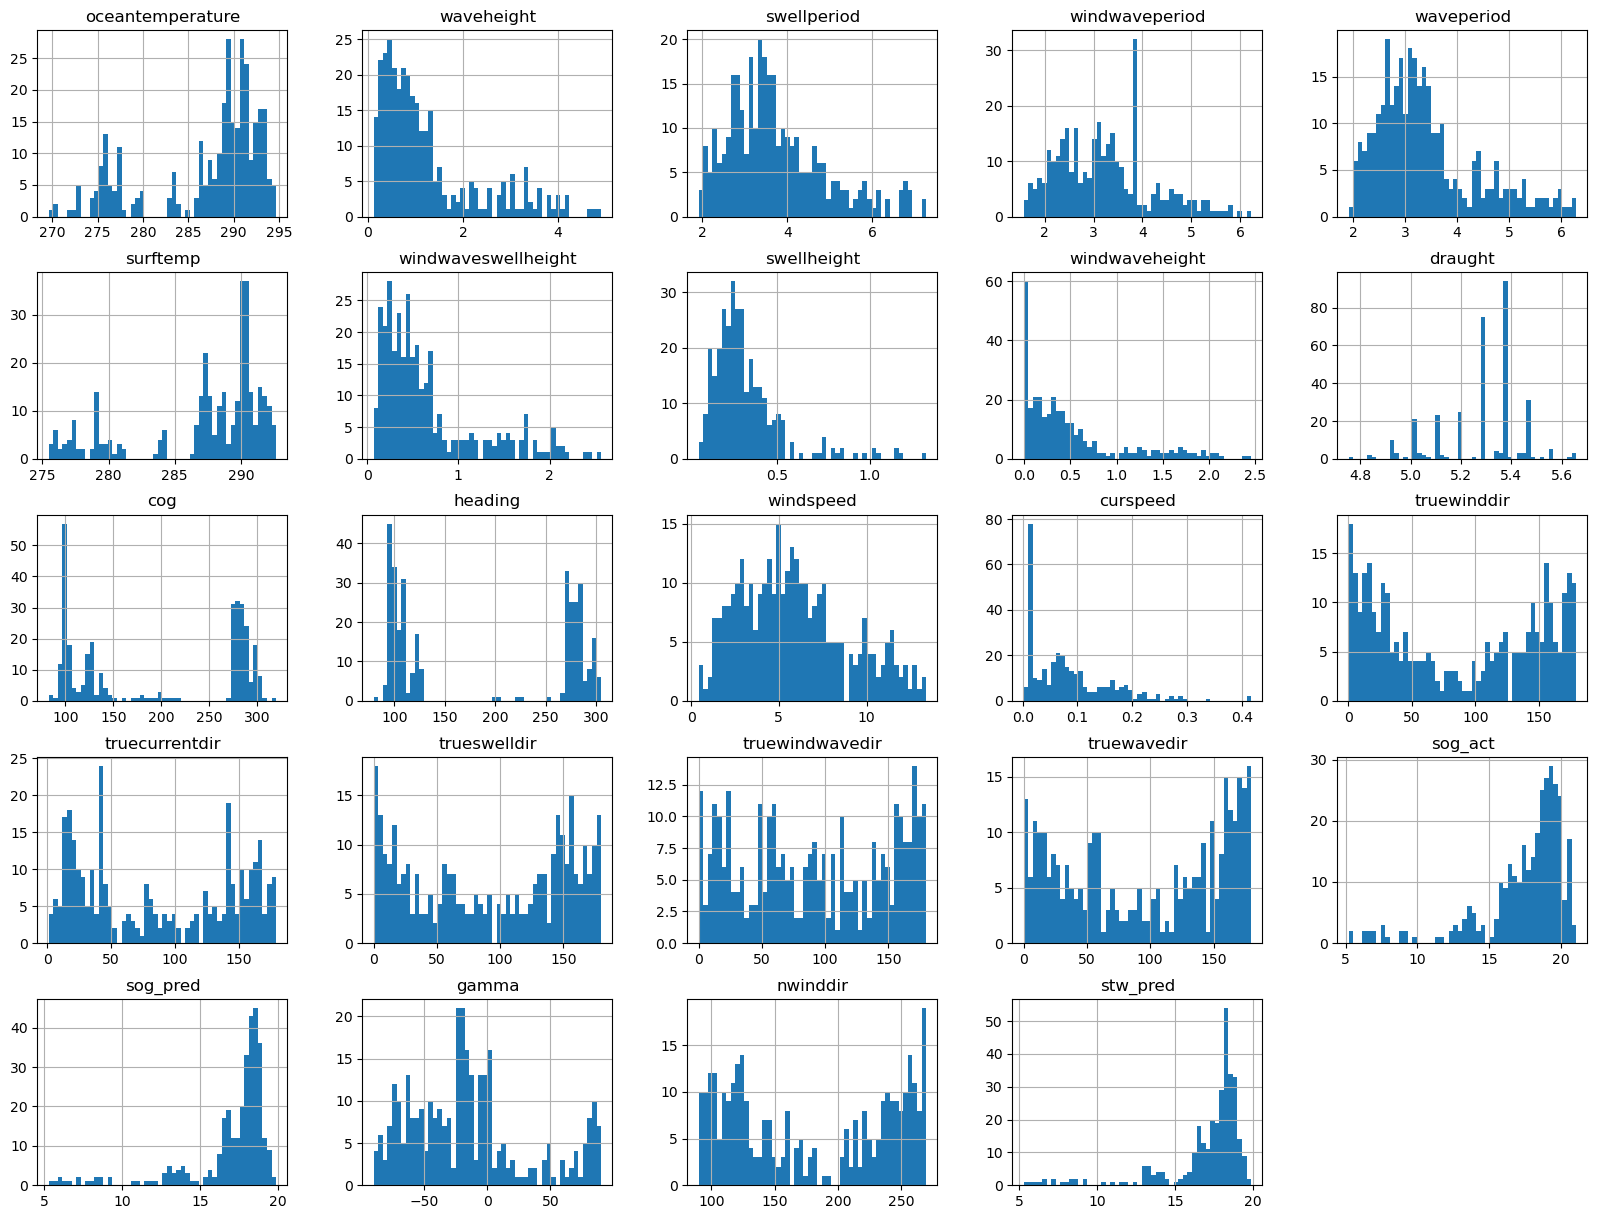

In [62]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
dfprog.hist(bins=50,figsize=(20,15))
plt.show()

In [63]:
# FOC in T/h
dfprog["foc_pred"] = ((dfprog["stw_pred"]/17.4)**3) * 0.88088 

In [64]:
dfprog.head(n=10)

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,truecurrentdir,trueswelldir,truewindwavedir,truewavedir,sog_act,sog_pred,gamma,nwinddir,stw_pred,foc_pred
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,164.871808,15.554049,66.843493,57.268527,18.998906,18.532150,85.654121,201.771601,18.263222,1.018594
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,153.650411,11.071672,60.455881,51.313932,19.334278,18.507278,70.585227,205.671971,18.086519,0.989314
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,153.031589,16.281358,57.086511,46.894106,18.911047,18.629329,70.557348,212.436488,18.148146,0.999461
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,153.643227,69.175152,55.507286,56.527939,13.854933,13.987405,80.584748,230.510505,13.409203,0.403160
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,41.766758,158.632374,159.050718,167.192888,9.305198,10.829396,89.447596,254.157471,10.532619,0.195379
127,277.399658,3.852527,6.907508,5.299354,6.061778,279.230591,2.021695,1.143225,1.607422,4.841530,...,36.203894,98.603207,126.285782,119.939682,20.935741,17.424789,85.735437,252.289134,17.710532,0.928889
128,275.499359,3.304548,6.816074,4.561194,5.927387,286.705762,1.754722,1.136414,1.240662,4.852890,...,16.745666,170.252415,173.337517,176.253205,12.419853,12.235935,87.870444,240.000273,12.570038,0.332108
130,276.370789,2.999140,6.680770,3.821632,5.959699,286.763584,1.585114,1.306714,0.837463,4.923635,...,148.640604,55.948144,59.314576,54.778275,20.447721,16.448165,-84.704755,248.405148,16.747957,0.785515
131,277.268555,3.283719,6.891045,4.686806,5.876345,279.216553,1.731217,1.167188,1.231018,4.925344,...,154.901600,57.732440,24.484072,41.385363,18.702889,16.465161,82.800757,264.710374,16.233139,0.715281
134,277.220703,2.827531,6.624643,4.262856,5.585643,279.216553,1.490863,1.038464,1.032349,5.202804,...,10.961510,144.135380,178.761731,159.775304,16.155258,16.377091,-78.378834,269.075598,16.108414,0.698920


In [65]:
dfprog.describe()

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,truecurrentdir,trueswelldir,truewindwavedir,truewavedir,sog_act,sog_pred,gamma,nwinddir,stw_pred,foc_pred
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,3.220000e+02,322.000000,...,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,287.133146,1.239376,3.728832,3.217315,3.394434,287.273322,0.656704,0.327167,5.044473e-01,5.282713,...,86.811052,91.767870,91.961256,96.153199,17.449699,17.014228,-15.089290,179.967365,17.003320,0.878013
std,6.306975,1.056385,1.142063,0.964671,0.964702,4.797884,0.542138,0.191126,5.559464e-01,0.162420,...,59.359251,60.792466,57.126304,61.695572,3.069944,2.769735,46.988186,63.036318,2.746968,0.285424
min,269.606903,0.123628,1.915932,1.570717,1.915993,275.485352,0.073242,0.073242,2.530000e-16,4.754639,...,1.295289,0.118457,0.113800,0.200645,5.224523,5.278971,-89.500098,90.107133,5.297674,0.024861
25%,285.292786,0.488767,2.886734,2.440019,2.692099,286.832031,0.272528,0.211311,1.016693e-01,5.199718,...,28.600108,29.561131,44.310938,35.663590,16.568861,16.684406,-50.925193,119.047681,16.646220,0.771287
50%,289.505615,0.859205,3.499382,3.122891,3.162097,289.004578,0.461562,0.278795,3.207703e-01,5.290842,...,79.271353,95.228275,90.122568,102.917500,18.413643,18.053087,-20.644262,170.499216,17.979417,0.971843
75%,291.391602,1.462465,4.301386,3.864905,3.734918,290.458008,0.770181,0.387970,6.242180e-01,5.381292,...,146.039105,149.331941,147.109277,158.650305,19.421633,18.578203,1.585855,244.414903,18.548733,1.067116
max,294.685303,4.908680,7.260825,6.225745,6.291378,292.665649,2.565230,1.306714,2.452637e+00,5.657671,...,179.405213,179.955359,179.922282,179.699225,21.031230,19.887268,89.975398,269.737370,19.902417,1.318216


In [69]:
foc_month = dfprog['foc_pred'].mean()
f"Mean of predicted FOC in a month is {foc_month} T//h"

'Mean of predicted FOC in a month is 0.8780125573264537 T//h'